# Разработка A/B-тестирования и анализ результатов

Вы работаете продуктовым аналитиком в компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В вашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Вас, как аналитика, просят помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

Вы будете работать с тремя таблицами:

- `history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. 

- `project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14.

- `project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. 

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `history.csv`, `project_test.csv`, `project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Ваши задачи: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе поработайте с историческими данными приложения:

- Импортируйте библиотеку pandas.

- Считайте и сохраните в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `history.csv`.

Выведите на экран первые пять строк полученного датафрейма.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import mannwhitneyu, ttest_ind
from statsmodels.stats.proportion import proportions_ztest



In [ ]:
sessions_history = pd.read_csv('history.csv')

In [3]:
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


In [4]:
sessions_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            435924 non-null  object
 1   session_id         435924 non-null  object
 2   session_date       435924 non-null  object
 3   session_start_ts   435924 non-null  object
 4   install_date       435924 non-null  object
 5   session_number     435924 non-null  int64 
 6   registration_flag  435924 non-null  int64 
 7   page_counter       435924 non-null  int64 
 8   region             435924 non-null  object
 9   device             435924 non-null  object
dtypes: int64(3), object(7)
memory usage: 33.3+ MB


In [5]:
sessions_history.describe()

,session_number,registration_flag,page_counter
count,435924.000000,435924.000000,435924.000000
mean,2.382908,0.077325,3.005561
std,1.288487,0.267107,1.024625
min,1.000000,0.000000,1.000000
25%,1.000000,0.000000,2.000000
50%,2.000000,0.000000,3.000000
75%,3.000000,0.000000,4.000000
max,10.000000,1.000000,7.000000


#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитайте количество уникальных сессий `session_id`.

- Выведите на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберите любого из них.

- Изучите таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [6]:
(pd.DataFrame({'Количество пропусков': sessions_history.isnull().sum(), 'Доля пропусков': sessions_history.isnull().mean().round(4), 'Количество дубликатов': sessions_history.duplicated().sum()}).style.background_gradient(cmap='coolwarm'))

,Количество пропусков,Доля пропусков,Количество дубликатов
user_id,0,0.000000,0
session_id,0,0.000000,0
session_date,0,0.000000,0
session_start_ts,0,0.000000,0
install_date,0,0.000000,0
session_number,0,0.000000,0
registration_flag,0,0.000000,0
page_counter,0,0.000000,0
region,0,0.000000,0
device,0,0.000000,0


Дубликатов и пропусков, не обнаружено. 

In [7]:
sessions_history.groupby('user_id', 
                                 as_index= False)['session_id'].nunique().sort_values(by= 'session_id', 
                                                                                      ascending= False).head(5)

,user_id,session_id
8948,10E0DEFC1ABDBBE0,10
55627,6A73CB5566BB494D,10
109383,D11541BAC141FB94,9
121862,E8ADFF2913E86056,9
131181,FA752AB58040C361,9


In [8]:
sessions_history[sessions_history['user_id'] == '10E0DEFC1ABDBBE0']

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


Таблица позволяет детально изучить поведение отдельного пользователя, включая его историю визитов, количество просмотренных страниц, само устройство и региональную принадлежность.








#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируйте, как менялось число регистраций в приложении за время его существования.

- Агрегируйте исторические данные и рассчитайте число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты считайте, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Постройте линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразите их на одном графике.

- Постройте отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

- На обоих графиках должны быть заголовок, подписанные оси X и Y, сетка и легенда.

In [9]:
nunique_id = sessions_history.groupby('session_date', as_index = False)['user_id'].nunique()
reg_id = sessions_history[sessions_history['registration_flag'] == 1].groupby('session_date',
                                                                                              as_index= False)['user_id'].count()

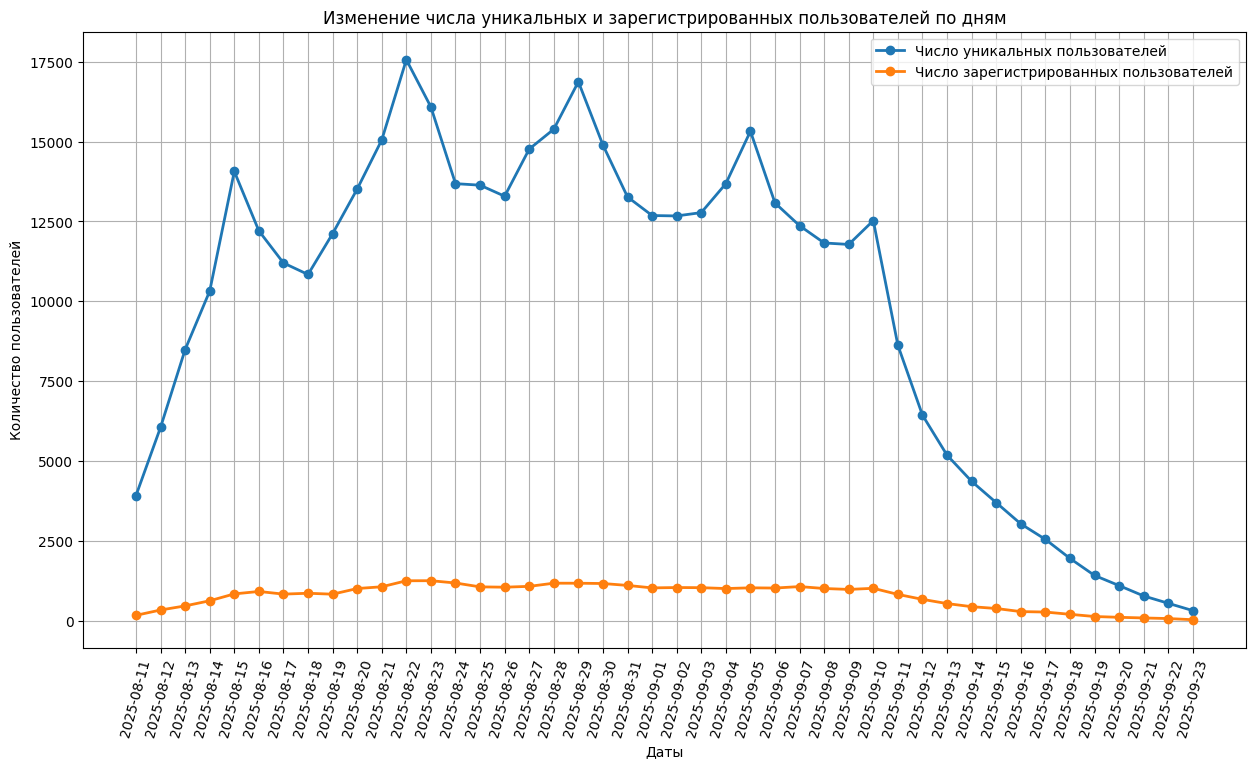

In [10]:
plt.figure(figsize= (15, 8))

plt.plot(nunique_id['session_date'], nunique_id['user_id'], marker='o', 
                                                            label='Число уникальных пользователей', 
                                                            linestyle='-', 
                                                            linewidth=2)
plt.plot(reg_id['session_date'], reg_id['user_id'], marker='o', 
                                                    label='Число зарегистрированных пользователей', 
                                                    linestyle='-', 
                                                    linewidth=2)

plt.title('Изменение числа уникальных и зарегистрированных пользователей по дням')
plt.xlabel('Даты')
plt.ylabel('Количество пользователей')

plt.legend()
plt.grid(True)
plt.xticks(rotation=75)

plt.show()

In [11]:
merged_data = nunique_id.merge(reg_id, on= 'session_date')

merged_data['reg_share'] = round(merged_data['user_id_y'] / merged_data['user_id_x'], 2)

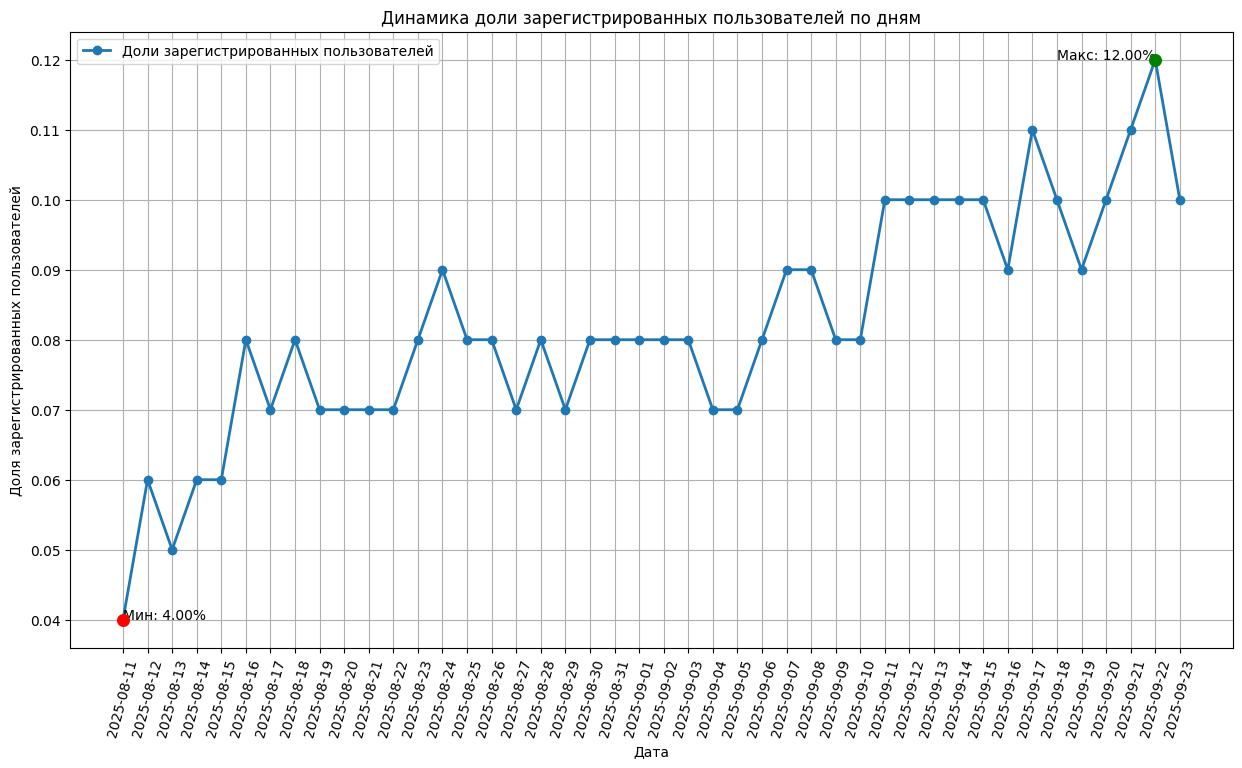

In [12]:
plt.figure(figsize= (15, 8))

plt.plot(merged_data['session_date'], merged_data['reg_share'], marker='o', 
                                                                label='Доли зарегистрированных пользователей', 
                                                                linestyle='-', 
                                                                linewidth=2)

max_idx = merged_data['reg_share'].idxmax()
plt.scatter(merged_data.iloc[max_idx]['session_date'], merged_data.iloc[max_idx]['reg_share'], color='green', s=70, zorder=5)
plt.text(merged_data.iloc[max_idx]['session_date'], merged_data.iloc[max_idx]['reg_share'], f"Макс: {merged_data.iloc[max_idx]['reg_share']:.2%}", ha="right")

min_idx = merged_data['reg_share'].idxmin()
plt.scatter(merged_data.iloc[min_idx]['session_date'], merged_data.iloc[min_idx]['reg_share'], color='red', s=70, zorder=5)
plt.text(merged_data.iloc[min_idx]['session_date'], merged_data.iloc[min_idx]['reg_share'], f"Мин: {merged_data.iloc[min_idx]['reg_share']:.2%}", ha="left")


plt.title('Динамика доли зарегистрированных пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Доля зарегистрированных пользователей')

plt.legend()
plt.grid(True)
plt.xticks(rotation=75)

plt.show()

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы на то, что он зарегистрируется и оплатит подписку.

- Найдите количество сессий для каждого значения количества просмотренных страниц. Например: одну страницу просмотрели в 29160 сессиях, две страницы в 105536 сессиях и так далее.

- Постройте столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

- На диаграмме должны быть заголовок, подписанные оси X и Y.

In [13]:
page_counter_session = sessions_history.groupby('page_counter', as_index= False)['session_id'].count()

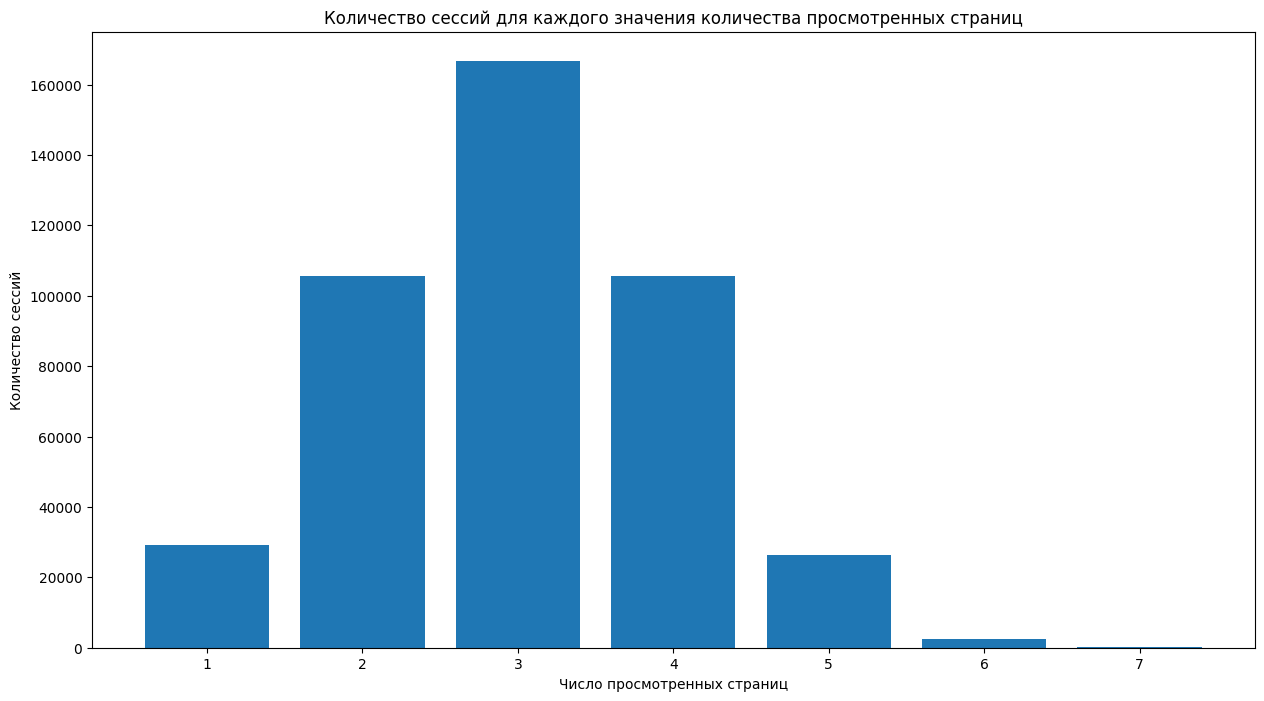

In [14]:
plt.figure(figsize= (15, 8))

plt.bar(page_counter_session['page_counter'], page_counter_session['session_id'])

plt.title('Количество сессий для каждого значения количества просмотренных страниц')
plt.xlabel('Число просмотренных страниц')
plt.ylabel('Количество сессий')

plt.show()

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Постройте график со средним значением доли успешных сессий ко всем сессиям по дням за весь период наблюдения.

In [15]:
sessions_history['good_session'] = 0

sessions_history.loc[sessions_history['page_counter'] >= 4, 'good_session'] = 1

In [16]:
group_good = sessions_history.groupby('session_date', as_index= False)['good_session'].mean()

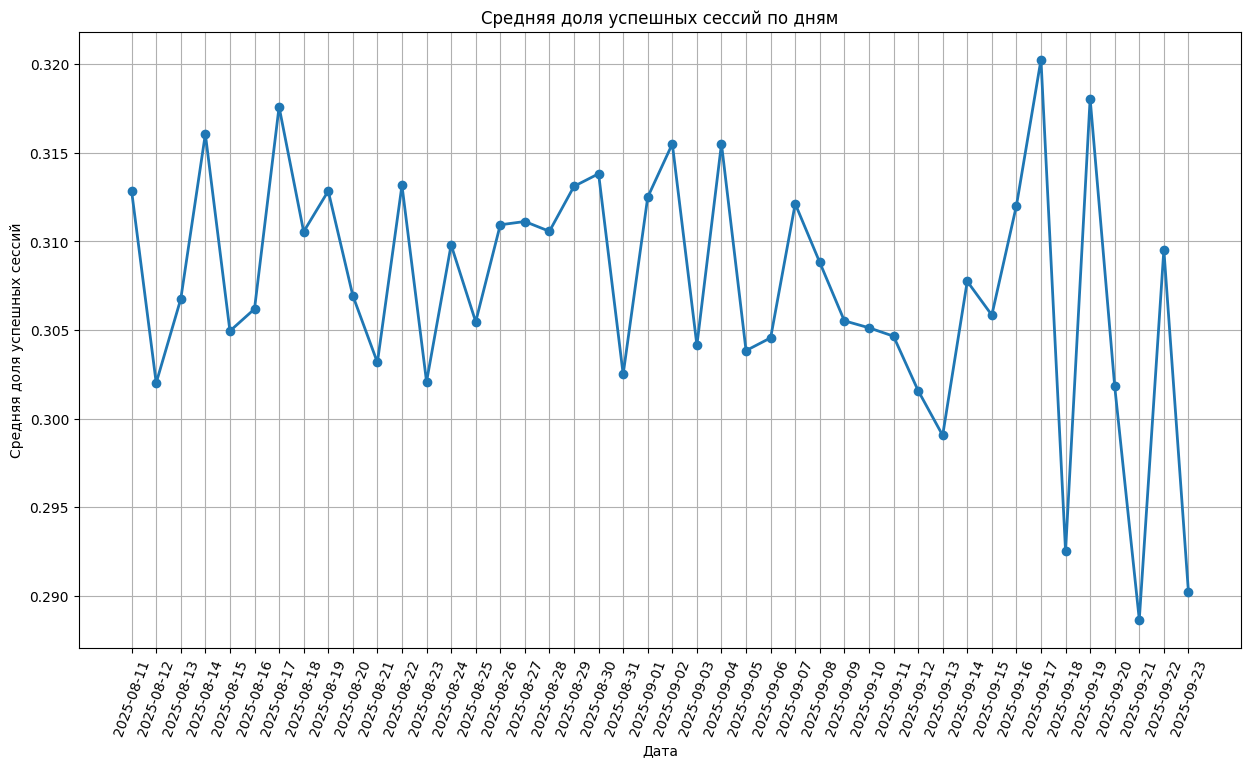

In [17]:
plt.figure(figsize= (15, 8))

plt.plot(group_good['session_date'], group_good['good_session'], marker= 'o',
                                                                 linestyle='-', 
                                                                 linewidth=2)

plt.title('Средняя доля успешных сессий по дням')
plt.xlabel('Дата')
plt.ylabel('Средняя доля успешных сессий')

plt.grid(True)
plt.xticks(rotation=70)

plt.show()

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика, рассчитать необходимую длительность проведения теста.

#### 2.1. Расчёт размера выборки
В рамках курса вам уже приходилось рассчитывать размеры выборки, используя онлайн-калькуляторы. В этом задании предлагаем воспользоваться готовым кодом и рассчитать необходимое для вашего дизайна эксперимента количество пользователей.

Для этого установите в коде ниже следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. Обратите внимание, что здесь нужно указать десятичную дробь, а не процент.

При расчёте размера выборки мы будем использовать метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

Запустите ячейку и изучите полученное значение.

In [18]:
from statsmodels.stats.power import NormalIndPower

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 0.8  # Мощность теста
mde = 0.03  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


#### 2.1. Расчёт длительности A/B-теста

Используйте данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитайте длительность теста, разделив одно на другое.

- Рассчитайте среднее количество уникальных пользователей приложения в день.

- Определите длительность теста, исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлите в большую сторону.

In [19]:
from math import ceil

# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = round(sessions_history.groupby('session_date')['user_id'].count().mean())

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil((sample_size * 2)/ avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907 пользователей в день составит 4 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Считайте и сохраните в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `project_test_part.csv`.

- Рассчитайте количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитайте и выведите на экран процентную разницу в количестве пользователей в группах A и B. Постройте любую удобную визуализацию, на которой можно было бы увидеть возможное различие двух групп.

Для расчёта процентной разницы воспользуйтесь формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [ ]:
sessions_test_part = pd.read_csv('project_test_part.csv')

In [21]:
sessions_test_part.head(5)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


In [22]:
group_a = sessions_test_part[sessions_test_part['test_group'] == 'A']
group_b = sessions_test_part[sessions_test_part['test_group'] == 'B']

group_a_nun = group_a.groupby('session_date', as_index= False)['user_id'].nunique()
group_b_nun = group_b.groupby('session_date', as_index= False)['user_id'].nunique()

In [23]:
int_set = list(set(group_a['user_id']) & set(group_b['user_id']))

int_set

[]

In [24]:
print(f"Kоличество уникальных пользователей группы А, для одного дня наблюдения {group_a_nun.at[0, 'user_id']}")

print(f"Kоличество уникальных пользователей группы В, для одного дня наблюдения {group_b_nun.at[0, 'user_id']}")

Kоличество уникальных пользователей группы А, для одного дня наблюдения 1477
Kоличество уникальных пользователей группы В, для одного дня наблюдения 1466


In [25]:
print(f"Процентная разница в количестве пользователей в группах A и B: {round(100 * (group_a_nun.at[0, 'user_id'] - group_b_nun.at[0, 'user_id']) / group_a_nun.at[0, 'user_id'], 3)}%")

Процентная разница в количестве пользователей в группах A и B: 0.745%


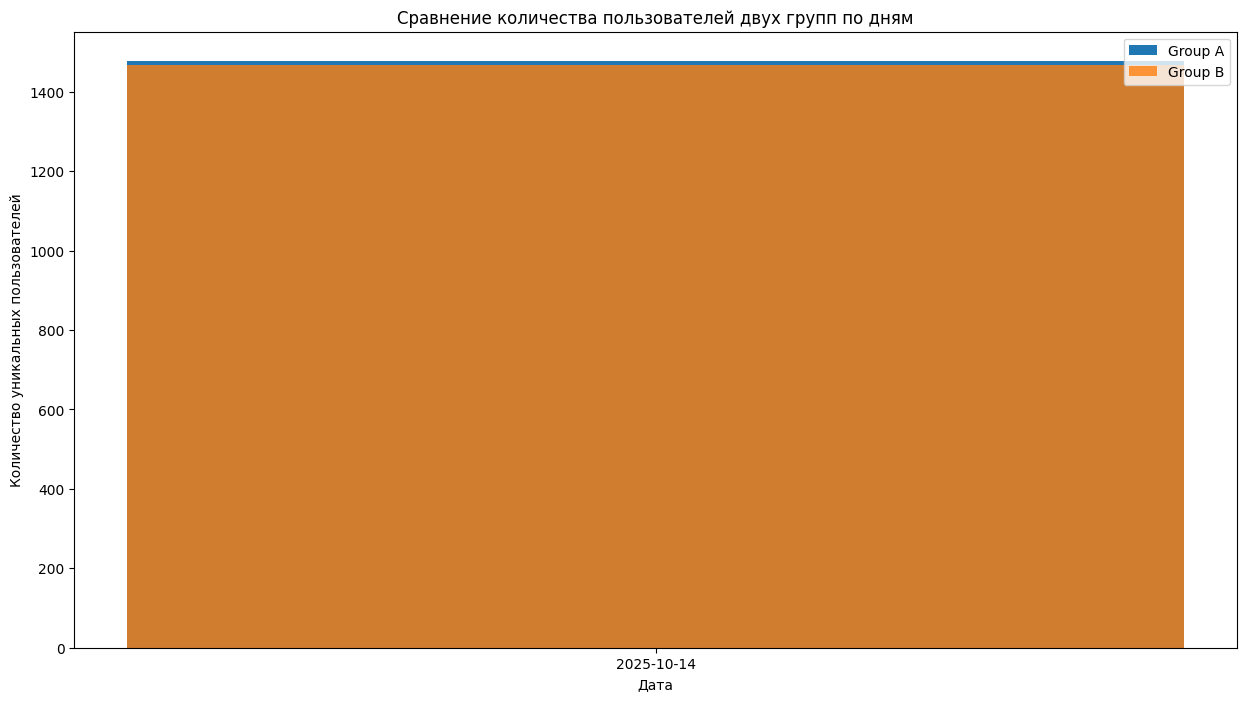

In [26]:
plt.figure(figsize=(15, 8))

plt.bar(group_a_nun['session_date'], group_a_nun['user_id'], label='Group A')
plt.bar(group_b_nun['session_date'], group_b_nun['user_id'], label='Group B', alpha= 0.8)

plt.xlabel('Дата')  
plt.ylabel('Количество уникальных пользователей')  
plt.title('Сравнение количества пользователей двух групп по дням')

plt.legend()  

plt.show()

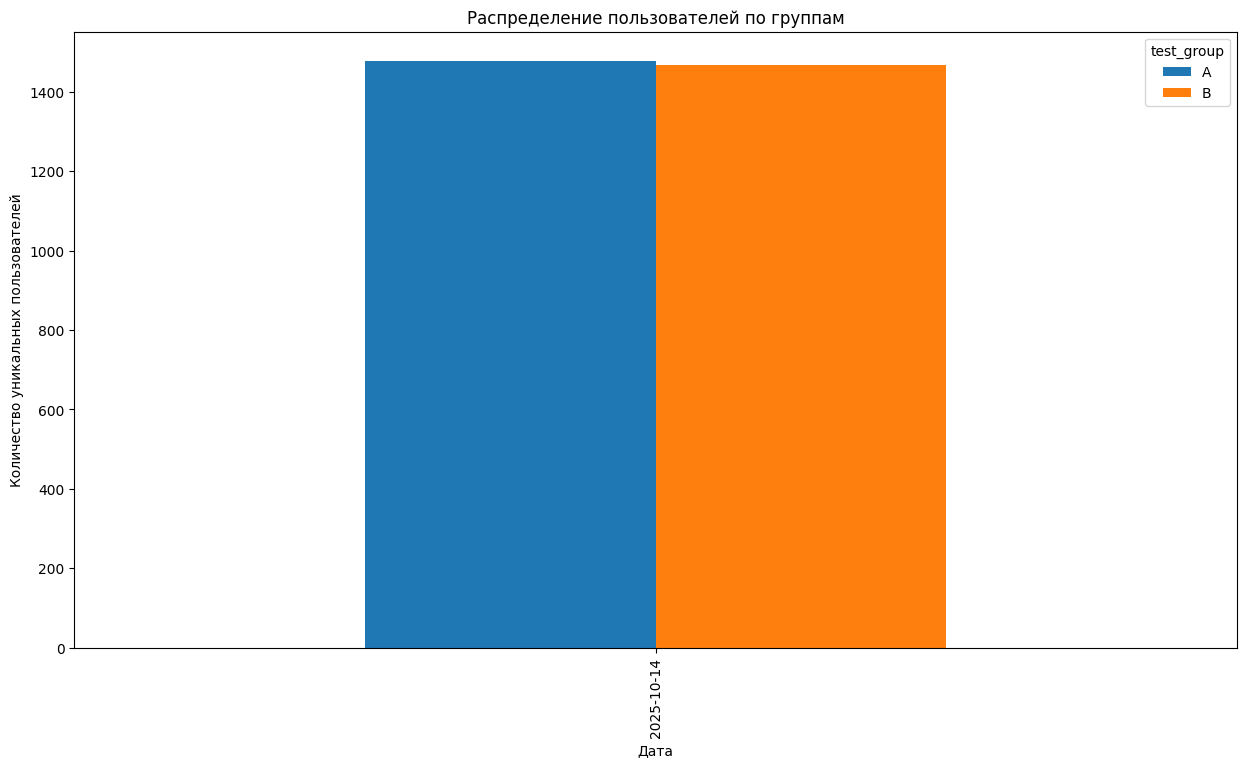

In [27]:
daily_users = sessions_test_part.groupby(['session_date', 'test_group'])['user_id'].nunique().unstack()

daily_users.plot(kind='bar', figsize=(15, 8))

plt.title('Распределение пользователей по группам')
plt.xlabel('Дата')  
plt.ylabel('Количество уникальных пользователей')   

plt.show()

#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройства и регионам.

Постройте две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение устройств в группах A и B.


In [28]:
device_a = group_a.groupby('device')['user_id'].nunique()
device_b = group_b.groupby('device')['user_id'].nunique()

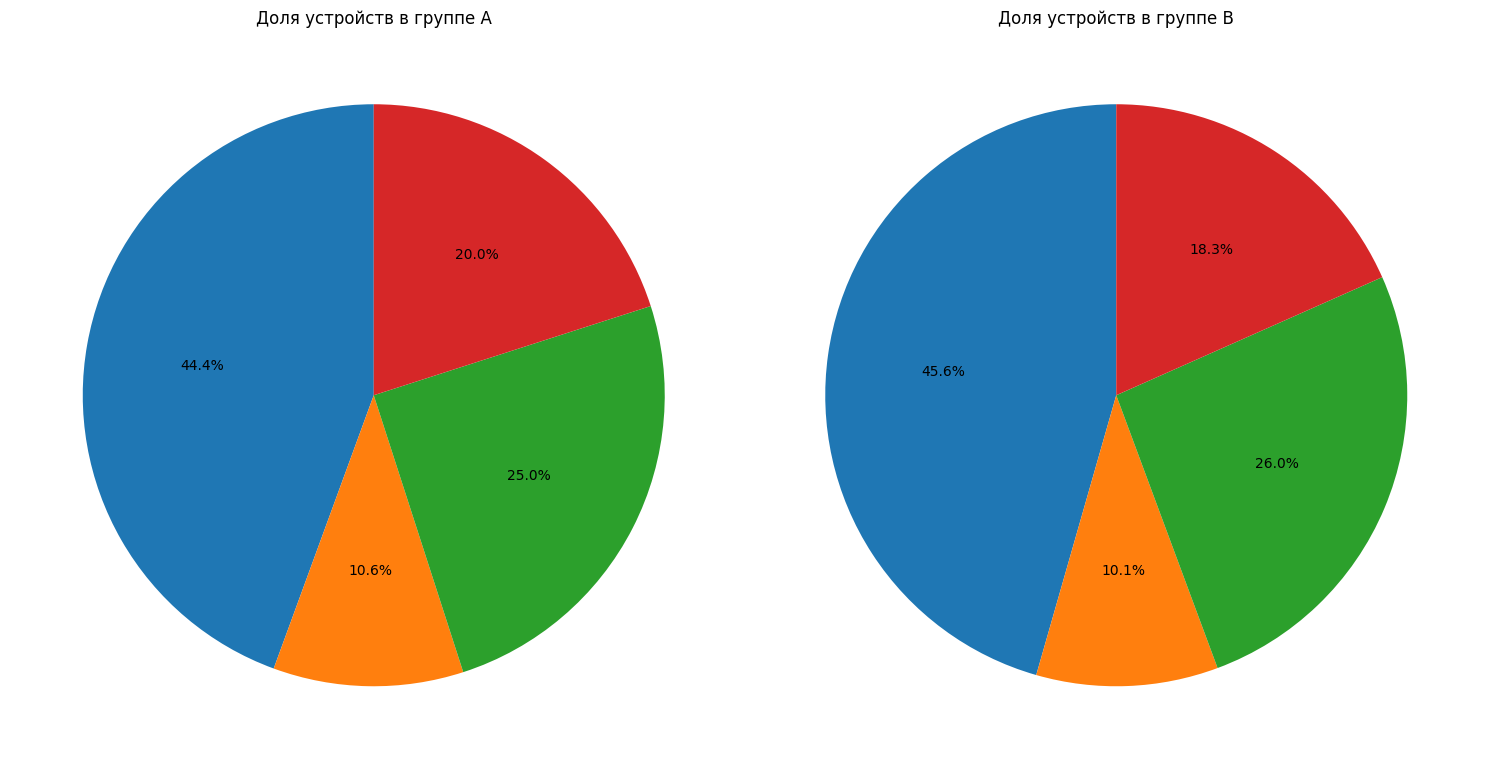

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

axes[0].pie(device_a, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Доля устройств в группе A')

axes[1].pie(device_b, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Доля устройств в группе B')

plt.tight_layout()
plt.show()

#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедитесь, что пользователи равномерно распределены по регионам.

Постройте две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение регионов в группах A и B. Постарайтесь использовать другой тип диаграммы, не тот, что в прошлом задании.


In [30]:
region_a = group_a.groupby('region', as_index= False)['user_id'].nunique()
region_b = group_b.groupby('region', as_index= False)['user_id'].nunique()

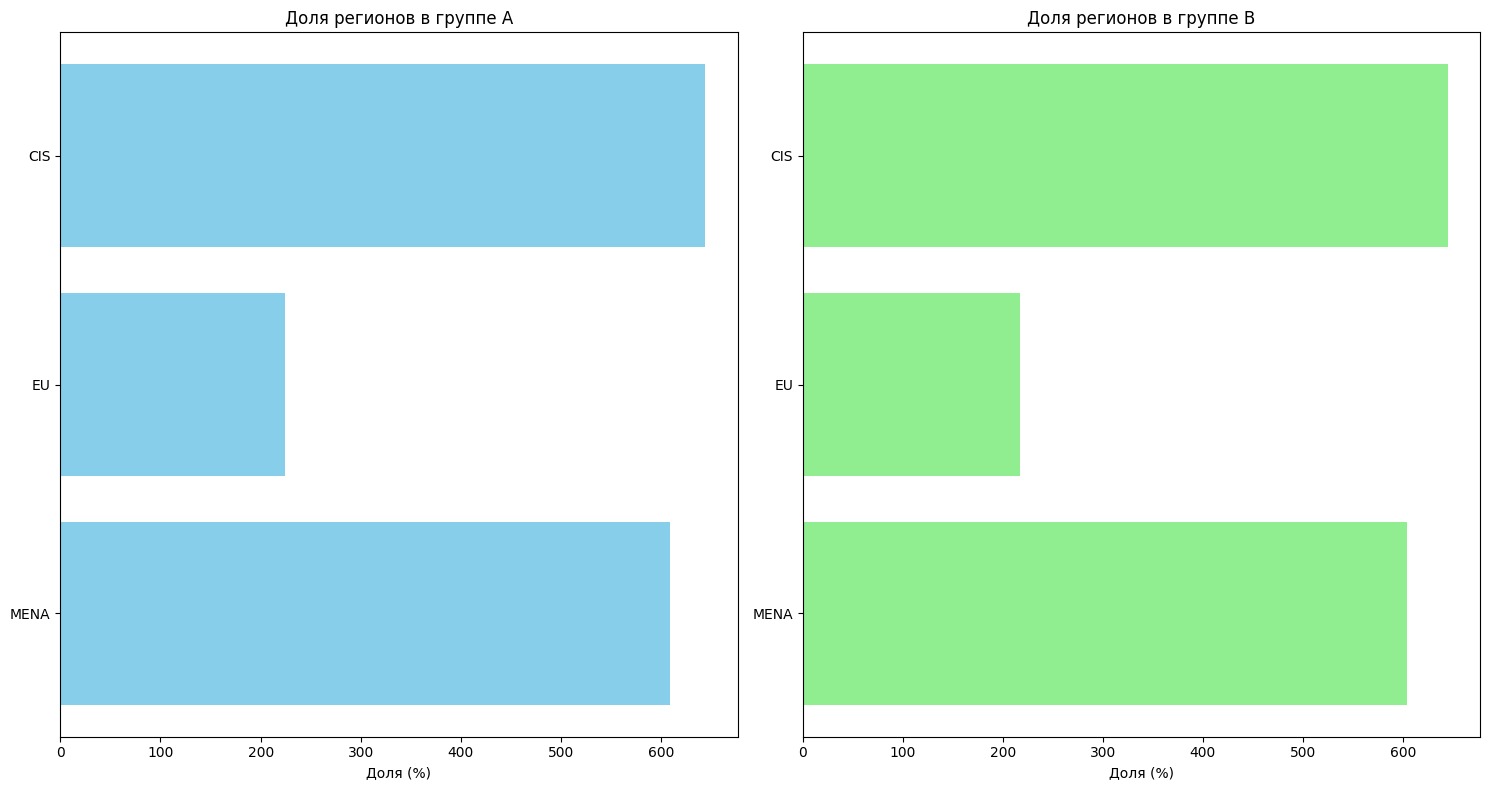

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

axes[0].barh(region_a['region'], region_a['user_id'], color='skyblue') 

axes[0].invert_yaxis()  

axes[0].set_xlabel('Доля (%)')
axes[0].set_title('Доля регионов в группе A')

axes[1].barh(region_b['region'], region_b['user_id'], color='lightgreen')

axes[1].invert_yaxis() 

axes[1].set_xlabel('Доля (%)')
axes[1].set_title('Доля регионов в группе B')

plt.tight_layout()
plt.show()

#### 3.5. Вывод после проверки A/B-теста

На основе проведённого анализа A/B-теста сформулируйте и запишите свои выводы. В выводе обязательно укажите:

- Были ли обнаружено различие в количестве пользователей в двух группах.

- Являются ли выборки независимыми. Было ли обнаружено пересечение пользователей из тестовой и контрольной групп.

- Сохраняется ли равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам.

Сделайте заключение о том, корректно ли проходит A/B-тест или наблюдаются какие-либо нарушения.

Исходные данные:
- Размер выборки: каждая группа должна содержать минимум 17441 участника.
- Длительность теста: рассчитано, что длительность теста при уровне трафика 9907 пользователей в сутки составляет примерно 4 дня.
- Уникальные пользователи: группа A — 1477 человек, группа B — 1466 человек.
- Разница между группами: процентная разница в числе участников между двумя группами составила всего лишь 0.745%.

Анализ показывает незначительную разницу в численности пользователей между группой A и группой B (0.745%). Это означает, что расхождение минимально и практически отсутствует статистически значимое отличие в распределении пользователей между этими группами. Таким образом, число участников в группе A незначительно превышает группу B, однако данное отклонение находится в пределах допустимой погрешности и не оказывает существенного влияния на итоговые показатели эксперимента.

При анализе было установлено отсутствие пересечения пользователей между тестовой и контрольной группами. Следовательно, каждая выборка является независимой от другой, что позволяет исключить возможность систематической ошибки.

Для подтверждения корректности тестирования также важно убедиться, что различия между пользователями внутри групп равномерно распределяются по таким важным признакам, как устройства и регионы. Что уже проверили.

На основании проведенного анализа мы можем заключить следующее:
- Размер выборок близок друг другу, процентное различие минимальное, что свидетельствует о правильном подборе объема экспериментальных групп.
- Отсутствует перекрестное попадание пользователей в разные группы, следовательно, выборки являются независимыми.
- Несмотря на небольшие различия в долях пользователей по типам устройств и регионам, общее распределение можно считать достаточно сбалансированным.

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у вас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

- Считайте и сохраните в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `project_test.csv`.

- В датафрейме `sessions_test` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [ ]:
sessions_test = pd.read_csv('project_test.csv')

In [33]:
sessions_test['good_session'] = 0

sessions_test.loc[sessions_test['page_counter'] >= 4, 'good_session'] = 1

In [34]:
sessions_test.head(3)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0


In [35]:
sessions_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100005 entries, 0 to 100004
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            100005 non-null  object
 1   session_id         100005 non-null  object
 2   session_date       100005 non-null  object
 3   session_start_ts   100005 non-null  object
 4   install_date       100005 non-null  object
 5   session_number     100005 non-null  int64 
 6   registration_flag  100005 non-null  int64 
 7   page_counter       100005 non-null  int64 
 8   region             100005 non-null  object
 9   device             100005 non-null  object
 10  test_group         100005 non-null  object
 11  good_session       100005 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 9.2+ MB


In [36]:
(pd.DataFrame({'Количество пропусков': sessions_test.isnull().sum(), 'Доля пропусков': sessions_test.isnull().mean().round(4), 'Количество дубликатов': sessions_test.duplicated().sum()}).style.background_gradient(cmap='coolwarm'))

,Количество пропусков,Доля пропусков,Количество дубликатов
user_id,0,0.000000,0
session_id,0,0.000000,0
session_date,0,0.000000,0
session_start_ts,0,0.000000,0
install_date,0,0.000000,0
session_number,0,0.000000,0
registration_flag,0,0.000000,0
page_counter,0,0.000000,0
region,0,0.000000,0
device,0,0.000000,0


In [37]:
min(sessions_test['session_date']), max(sessions_test['session_date'])

('2025-10-14', '2025-11-02')

#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и вы будете сравнивать две сопоставимые группы.

- Рассчитайте количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверьте, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы. Используйте статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

- В качестве ответа выведите на экран полученное значение p-value и интерпретируйте его.

In [38]:
project_test_a = sessions_test[sessions_test['test_group'] == 'A']
project_test_b = sessions_test[sessions_test['test_group'] == 'B']

test_a_nun = project_test_a.groupby('session_date', as_index= False)['session_id'].nunique()
test_b_nun = project_test_b.groupby('session_date', as_index= False)['session_id'].nunique()

In [39]:
project_test_set = list(set(project_test_a['user_id']) & set(project_test_b['user_id']))

project_test_set

[]

In [40]:
statistic, p_value = mannwhitneyu(test_a_nun['session_id'], test_b_nun['session_id'])

print(f'p-значение: {p_value:.4f}')

if p_value > 0.05:
    print("Средние количества уникальных дневных сессий в двух выборках существенно не различаются.")
else:
    print("Есть основания считать, что средние количества уникальных дневных сессий в двух выборках различаются.")

p-значение: 0.8817
Средние количества уникальных дневных сессий в двух выборках существенно не различаются.


In [41]:
statistic, p_value = ttest_ind(test_a_nun['session_id'], test_b_nun['session_id'])

print(f'p-значение: {p_value:.4f}')

if p_value > 0.05:
    print("Средние количества уникальных дневных сессий в двух выборках существенно не различаются.")
else:
    print("Есть основания считать, что средние количества уникальных дневных сессий в двух выборках различаются.")

p-значение: 0.9382
Средние количества уникальных дневных сессий в двух выборках существенно не различаются.


#### 4.3. Сравнение доли успешных сессий

Когда вы убедились, что количество сессий в обеих выборках не различалось, можно переходить к анализу ключевой метрики — доли успешных сессий.

Используйте созданный на первом шаге задания столбец `good_session` и рассчитайте долю успешных сессий для выборок A и B, а также разницу в этом показателе. Полученный вывод отобразите на экране.

In [42]:
share_A_good = round(project_test_a['good_session'].sum() / sessions_test['good_session'].sum(), 2)
share_B_good = round(project_test_b['good_session'].sum() / sessions_test['good_session'].sum(), 2)

In [43]:
print(f'Доля успешных сессий для выбороки A: {share_A_good}%')

print(f'Доля успешных сессий для выбороки В: {share_B_good}%')

print(f'Разница между долями успешных сессий для выборок A и B: {round(share_A_good - share_B_good, 2)}%')

Доля успешных сессий для выбороки A: 0.49%
Доля успешных сессий для выбороки В: 0.51%
Разница между долями успешных сессий для выборок A и B: -0.02%


#### 4.4. Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге вы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

- Используя статистический тест, рассчитайте, является ли изменение в метрике доли успешных сессий статистически значимым.

- Выведите на экран полученное значение p-value и свои выводы о статистической значимости. Напомним, что уровень значимости в эксперименте был выбран на уровне 0.05.

In [44]:
m_A = project_test_a['good_session'].sum()
m_B = project_test_b['good_session'].sum()

n_A = project_test_a['good_session'].shape[0]
n_B = project_test_b['good_session'].shape[0]

p_A, p_B = m_A / n_A, m_B / n_B

In [45]:
print(f'Kоличество успехов для группы A: {m_A}, Kоличество успехов для группы B: {m_B}')

print(f'Pазмер группы A: {n_A}, Pазмер группы B: {n_B}')

Kоличество успехов для группы A: 15248, Kоличество успехов для группы B: 16059
Pазмер группы A: 49551, Pазмер группы B: 50454


In [46]:
if (p_A * n_A > 10) and ((1 - p_A) * n_A > 10) and (p_B * n_B > 10) and ((1 - p_B) * n_B > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

Предпосылка о достаточном количестве данных выполняется!


In [47]:
stat_ztest, p_value_ztest = proportions_ztest( # проведите Z-тест пропорций
	[m_A, m_B],
	[n_A, n_B]
)

print(f'pvalue={p_value_ztest}') # выведите полученное p-value 

if p_value_ztest > alpha:
    print('Нулевая гипотеза находит подтверждение!')
else:
    print('Нулевая гипотеза не находит подтверждения!')

pvalue=0.0003149479976072246
Нулевая гипотеза не находит подтверждения!


#### 4.5. Вывод по результатам A/B-эксперимента

На основе проведённого анализа результатов теста сформулируйте и запишите свои выводы для команды разработки приложения. В выводе обязательно укажите:

- Характеристики проведённого эксперимента, количество задействованных пользователей и длительность эксперимента.

- Повлияло ли внедрение нового алгоритма рекомендаций на рост ключевой метрики и как.

- Каким получилось значение p-value для оценки статистической значимости выявленного эффекта.

- Стоит ли внедрять новоовведение в приложение.

Характеристики эксперимента:
Эксперимент проводился для проверки влияния нового алгоритма рекомендаций на успешность пользовательских сессий. Всего было привлечено 99995 пользователей, распределённых поровну между двумя группами:  
- Группа А (контрольная группа): 49551 пользователей и количество успехов для группы 15248.
- Группа В (экспериментальная группа): 50454 пользователей и количество успехов для группы 16059.
Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907 пользователей в день составит 2 дней.

Результаты тестов:
Для сравнения средних значений количества уникальных ежедневных сессий были проведены два теста:  
- Тест Манна-Уитни: p-значение = 0.8817, значит средние значения не отличаются значительно.
- T-тест: p-значение = 0.9382, также подтверждает отсутствие значимых различий.

Однако доли успешных сессий показали различия:  
- Доля успешных сессий в группе А составила 0.49%.  
- Доля успешных сессий в группе В увеличилась до 0.51%.
Это означает увеличение доли успешных сессий на 0.02% в пользу экспериментальной группы. Полученное p-значение составило 0.000315, что свидетельствует о высокой статистической значимости результата.

Выводы:
Новый алгоритм рекомендаций оказал положительное влияние на ключевую метрику — долю успешных сессий. Хотя абсолютное изменение невелико (+0.02%), оно является статистически значимым. Это позволяет сделать следующие выводы:  
- Достаточное количество участников и однородность групп обеспечили надежность выводов.  
- Новый алгоритм увеличил долю успешных сессий среди пользователей, что потенциально способствует улучшению общей удовлетворенности пользователей приложением.  
- Значение p-value (0.0003) подтвердило значимость полученного эффекта.

Таким образом, новый алгоритм рекомендуется внедрить в продуктовую версию приложения. Даже небольшой прирост показателя успеха способен положительно повлиять на поведение пользователей и повысить лояльность аудитории.